**Name:** Luan Minh Tran

**NetID:** lmt185

**RUID:** 197002611

### Problem Statement
Fine-tune the ResNet 18 network to
classify the MNIST dataset. Report the confusion matrix, the accuracy, the f-score,
precision and recall of your classifier.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import time
import os
import copy

In [32]:
# TODO: Load MNIST dataset (train & test sets)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
MNIST_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,transform=transform)
MNIST_test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
indices = list(range(len(MNIST_train_set)))

np.random.shuffle(indices)
split = int(np.floor(0.2*len(MNIST_train_set)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

train_set_loader = DataLoader(MNIST_train_set, sampler= train_sample ,batch_size=64)
valid_set_loader = DataLoader(MNIST_train_set, sampler= valid_sample, batch_size=64)
test_set_loader = DataLoader(MNIST_test_set, batch_size=128, shuffle= True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class_names = MNIST_train_set.classes
# dataset_sizes = len(MNIST_train_set)

In [3]:
class MyResNet(nn.Module):

    def __init__(self, in_channels=1, class_names = class_names):
        super(MyResNet, self).__init__()

        # bring resnet
        self.model = torchvision.models.resnet18()

        # original definition of the first layer on the renset class
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # your case
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = 512
        self.model.fc = nn.Linear(num_ftrs, len(class_names))
    def forward(self, x):
        return self.model(x)


In [4]:
# TODO: Load pretrained model
# TODO: Update network to handle different number of output classes
# TODO: Create an optimizer to update weights of the network

model_ft = MyResNet()
# num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# criterion = nn.KLDivLoss()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.002, momentum=0.8)
# optimizer_ft = optim.Adadelta(model_ft.parameters(), lr=0.002, rho=0.9, eps=1e-06, weight_decay=0)



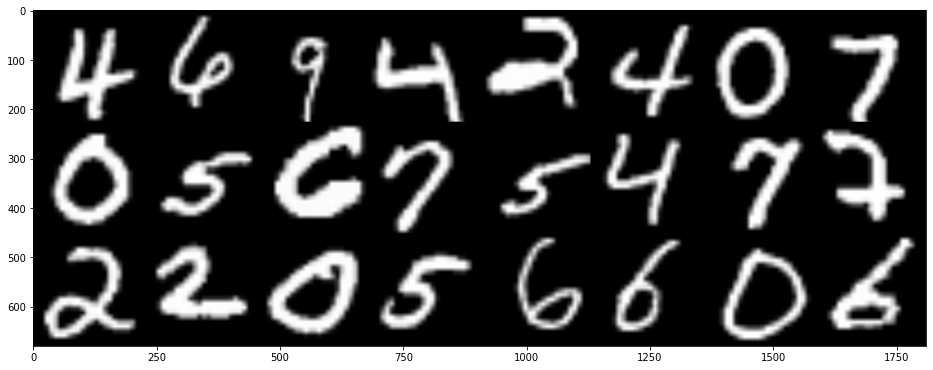

In [5]:
samples, labels = iter(train_set_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [7]:
# TODO: Train on MNIST dataset
def train_model(model, criterion, optimizer, epochs):
    train_loss =[]
    valid_loss = []
    valid_loss_min = np.Inf
    for e in range(epochs):
        running_loss = 0
        v_loss = 0
      
        for images, labels in train_set_loader:
          images, labels = images.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()*images.size(0)

        for images, labels in valid_set_loader:
          images, labels = images.to(device), labels.to(device)
          outputs_val = model(images)
          loss = criterion(outputs_val,labels)

          v_loss += loss.item()*images.size(0)

        tra_loss = running_loss / len(train_set_loader.sampler)
        val_loss = v_loss / len(valid_set_loader.sampler)

            # scheduler.step()
        print("Epoch : {}/{}..".format(e+1,epochs),
         "Training Loss: {:.6f}".format(tra_loss),
         "Validation Loss: {:.6f}".format(val_loss)) 
        train_loss.append(tra_loss)
        valid_loss.append(val_loss)

        if val_loss < valid_loss_min:
          torch.save(model.state_dict(),'model.pt')
          valid_loss_min = val_loss

    plt.plot(train_loss,label="Training Loss")
    plt.plot(valid_loss,label="Validation Loss")
    plt.legend
    plt.show()

    return model 

Epoch : 1/10.. Training Loss: 1.766484 Validation Loss: 1.183491
Epoch : 2/10.. Training Loss: 0.752578 Validation Loss: 0.467653
Epoch : 3/10.. Training Loss: 0.326913 Validation Loss: 0.244974
Epoch : 4/10.. Training Loss: 0.202107 Validation Loss: 0.176268
Epoch : 5/10.. Training Loss: 0.149277 Validation Loss: 0.145081
Epoch : 6/10.. Training Loss: 0.123197 Validation Loss: 0.119436
Epoch : 7/10.. Training Loss: 0.105358 Validation Loss: 0.110420
Epoch : 8/10.. Training Loss: 0.091334 Validation Loss: 0.094677
Epoch : 9/10.. Training Loss: 0.080208 Validation Loss: 0.090884
Epoch : 10/10.. Training Loss: 0.073733 Validation Loss: 0.083833


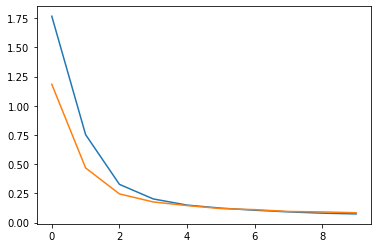

In [8]:
model_ft = train_model(model_ft,criterion, optimizer_ft, epochs=10)

In [9]:
# TODO: Test network on test set of MNIST dataset
test_loss = 0
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]

model_ft.eval()
for images, labels in test_set_loader:
  images, labels = images.to(device), labels.to(device)
  output = model_ft(images)
  loss = criterion(output,labels) # Calculate  loss
  test_loss += loss.item()*images.size(0) # Update loss

  _, pred = torch.max(output, dim = 1)
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label]+=correct[i].item()
    class_total[label]+=1

test_loss=test_loss / len(test_set_loader.sampler)
print("Test Loss: {:.6f}".format(test_loss))

for i in range(10):
  if class_total[i]>0:
    print(f'Test accuracy of {i}: {100*class_correct[i]/class_total[i]} %')
  else: 
    print('Test Training sample Accuracy:N/A')

print(f'Test accuracy overall: {100.*np.sum(class_correct)/np.sum(class_total)} %')

Test Loss: 0.068503
Test accuracy of 0: 98.46938775510205 %
Test accuracy of 1: 99.20704845814979 %
Test accuracy of 2: 98.25581395348837 %
Test accuracy of 3: 99.4059405940594 %
Test accuracy of 4: 97.55600814663951 %
Test accuracy of 5: 98.20627802690584 %
Test accuracy of 6: 97.28601252609603 %
Test accuracy of 7: 98.34630350194553 %
Test accuracy of 8: 97.94661190965093 %
Test accuracy of 9: 97.22497522299307 %
Test accuracy overall: 98.21 %


torch.Size([64, 1, 224, 224])


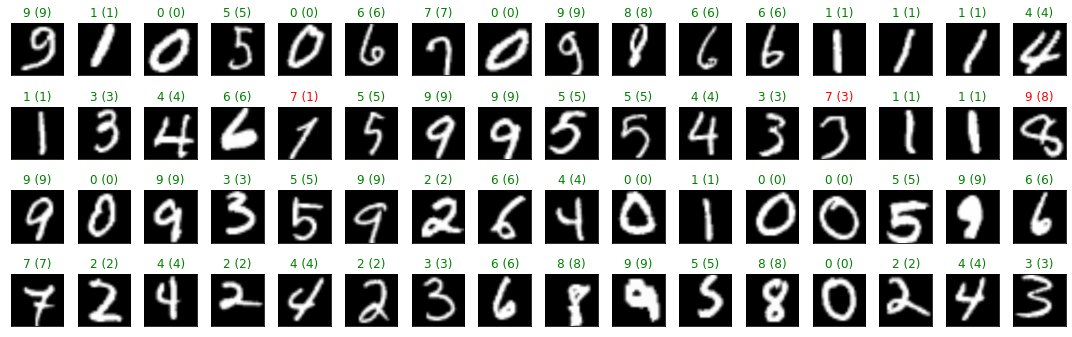

In [35]:
# TODO: Display and analyze results
data_iter = iter(train_set_loader)
images,labels = data_iter.next()
images, labels = images.to(device), labels.to(device)
output = model_ft(images)
_,pred = torch.max(output,dim=1)

images = images.to('cpu')
print(images.shape)

fig = plt.figure(figsize=(15,5))
for idx in np.arange(64):
  ax = fig.add_subplot(4,64/4,idx+1,xticks=[],yticks=[])
  ax.imshow(np.squeeze(images[idx]),cmap='gray')
  ax.set_title("{} ({})".format(str(pred[idx].item()),str(labels[idx].item())),color = 'green' if pred[idx]==labels[idx] else 'red')
  fig.tight_layout()

In [36]:
from sklearn.metrics import confusion_matrix
from itertools import product

In [37]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Greens):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks,classes)
  plt.yticks(tick_marks,classes)
  thresh = cm.max()/2
  for i,j in product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j]>thresh else 'black')
  plt.tight_layout()
  plt.ylabel('Target label')
  plt.xlabel('Predicted label')

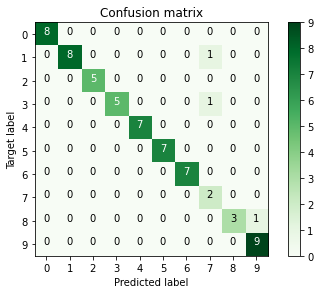

In [38]:
labels = labels.to('cpu')
pred = pred.to('cpu')
class_label = list(set(labels.numpy()))
con_matrix = confusion_matrix(y_true=labels,y_pred = pred)
plot_confusion_matrix(cm=con_matrix,classes=class_label,title='Confusion matrix')

In [39]:
precision = [con_matrix[i,i]/sum(con_matrix[i,:]) for i in range(len(class_label))]
recall = [con_matrix[i,i]/sum(con_matrix[:,i]) for i in range(len(class_label))]
f1_score = [2*precision[i]*recall[i]/(recall[i]+precision[i]) for i in range(len(class_label))]

for i in range(len(class_label)):
  print('For label {} Precision: {:.6f} Recall: {:.6f} F1Score: {:.6f} '.format(class_label[i],precision[i],recall[i],f1_score[i]))

For label 0 Precision: 1.000000 Recall: 1.000000 F1Score: 1.000000 
For label 1 Precision: 0.888889 Recall: 1.000000 F1Score: 0.941176 
For label 2 Precision: 1.000000 Recall: 1.000000 F1Score: 1.000000 
For label 3 Precision: 0.833333 Recall: 1.000000 F1Score: 0.909091 
For label 4 Precision: 1.000000 Recall: 1.000000 F1Score: 1.000000 
For label 5 Precision: 1.000000 Recall: 1.000000 F1Score: 1.000000 
For label 6 Precision: 1.000000 Recall: 1.000000 F1Score: 1.000000 
For label 7 Precision: 1.000000 Recall: 0.500000 F1Score: 0.666667 
For label 8 Precision: 0.750000 Recall: 1.000000 F1Score: 0.857143 
For label 9 Precision: 1.000000 Recall: 0.900000 F1Score: 0.947368 
